## CS-E4740 - Federated Learning D (Spring 25)

# Assignment 6: Trustworthy FL

### A. Pavlyuk, A. Jung, and ChatGPT

<a id='varying_features'></a>
<div class="alert alert-warning">
    <h2>Deadline: 14.04.2025</h2>
</div>

<a id='varying_features'></a><div class="alert alert-info">

## Learning Goals
After completing the notebook, you should
    
- know how to ensure subjective explainability in GTV minimization (GTVMin) based methods,
- be aware of privacy attacks on GTVMin-based methods.


## Background Material

1. Chapters 8 and 9 of [FLBook](https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FLBook.pdf)
2. [Documentation of Python library networkx](https://networkx.org/)

## Notebook Structure
1. The notebook consists of two parts: coding tasks (referred to as Task) and quiz questions (referred as Question). 
2. Both Tasks and Questions use a point-separated index X.Y, where X is the number of the notebook and Y is the number of the task/question in the X'th notebook.

## Importing necessary libraries

In [10]:
# General
import copy # Provides shallow and deep copy operations for objects
import numpy as np # NumPy for numerical computations and array manipulations
import pandas as pd # Pandas for data manipulation and analysis
from datetime import datetime # Handles date and time operations
from numpy import linalg as LA # Linear algebra functions
import matplotlib.pyplot as plt # Matplotlib for data visualization

# Scikit-learn methods
from sklearn.neighbors import kneighbors_graph # Computes the k-nearest neighbor graph
from sklearn.metrics import mean_squared_error # Measures the mean squared error for regression tasks
from sklearn.preprocessing import StandardScaler # Standardizes features by removing the mean and scaling to unit variance
from sklearn.model_selection import train_test_split # Splits datasets into training and testing subsets

# We will use NetworkX objects to store empirical graphs, local datasets, and models.
import networkx as nx # NetworkX helps in creating, manipulating, and analyzing graph structures

## Helper functions

In [11]:
def plotFMI(G, show_IDs=True, nodes_red=[]): 
    """
    Plots FMI stations on a scatter plot, with options to highlight specific nodes in red 
    and label them using either user names or node IDs.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node represents an FMI station, containing:
        - 'coord' (tuple: latitude, longitude) for spatial positioning.
        - 'user_name' (str or None) for optional labeling.

    show_IDs : bool, optional (default=True)
        If True, labels nodes without a 'user_name' attribute using their index.

    nodes_red : list of int, optional (default=[])
        A list of node indices to be highlighted in red.

    Returns
    -------
    None
        Displays a scatter plot where:
        - Nodes with a 'user_name' are colored blue and labeled with their name.
        - Nodes without a 'user_name' are black (unless in `nodes_red`, then red).
        - Edges are drawn in gray.
        - The plot is restricted to the coordinate range (18.5 ≤ longitude ≤ 31.5, 59 ≤ latitude ≤ 71).
    """
    # Extract coordinates
    coords = np.array([G.nodes[node]['coord'] for node in G.nodes])

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Add nodes with labels
    for node, (lat, lon) in enumerate(coords):
        user_name = G.nodes[node]['user_name']
        if user_name != None:
            if node in nodes_red:
                ax.scatter(coords[node, 1], coords[node, 0], color='red', s=10, zorder=5)
            else:
                ax.scatter(coords[node, 1], coords[node, 0], color='blue', s=10, zorder=5)
            ax.text(lon + 0.7, lat - 0.5, user_name, fontsize=16, ha='center', va='center', color='blue', fontweight='bold')
        else:
            if node in nodes_red:
                ax.scatter(coords[node, 1], coords[node, 0], color='red', s=10, zorder=5)
            else:
                ax.scatter(coords[node, 1], coords[node, 0], color='black', s=10, zorder=5)
            if show_IDs:
                ax.text(lon + 0.1, lat + 0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')

    # Draw edges
    for u, v in G.edges:
        ax.plot([coords[u, 1], coords[v, 1]], [coords[u, 0], coords[v, 0]], linestyle='-', color='gray')
        
    # Set axis limits
    ax.set_xlim(18.5, 31.5)
    ax.set_ylim(59, 71)

    # Set labels and title
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title('FMI stations')
    
    # Stretch according to Tissot's indicatrix
    ax.set_aspect(1.6)
    plt.show()
    
def add_edges(G, numneighbors=4):
    """Adds edges to a graph based on k-nearest neighbors using station coordinates.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node has a 'coord' attribute with (latitude, longitude).
    numneighbors : int, optional
        Number of nearest neighbors to connect to each node, by default 4.

    Returns
    -------
    networkx.Graph
        A new graph with added edges based on k-nearest neighbors.
    """
    # Deep copy the graph to avoid modifying the original
    graph_with_edges = copy.deepcopy(G)

    # Extract coordinates
    coords = np.array([graph_with_edges.nodes[node]['coord'] for node in graph_with_edges.nodes])

    # Create adjacency matrix using k-nearest neighbors
    adjacency_matrix = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)

    # Add edges based on the adjacency matrix
    edges = zip(*adjacency_matrix.nonzero())
    graph_with_edges.add_edges_from(edges)

    return graph_with_edges

def ExtractFeatureMatrixLabelVector(data):
    """Extracts feature matrix and label vector from FMI weather data.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing columns "Latitude", "Longitude", "temp", "Timestamp".
    
    Returns
    -------
    X : numpy.ndarray
        Feature matrix where each row corresponds to a data point.
    y : numpy.ndarray
        Label vector where each entry corresponds to the temperature value of a data point.
    """
    # Extract temperature and normalize the latitude and longitude
    temps = data['temp'].values
    latitudes = data['Latitude'].values / 100
    longitudes = data['Longitude'].values / 100

    # Extract time-based features (year, month, day, hour, minute)
    timestamps = data['Timestamp']
    year = timestamps.dt.year / 2025
    month = timestamps.dt.month / 13
    day = timestamps.dt.day / 32
    hour = timestamps.dt.hour / 25
    minute = timestamps.dt.minute / 61

    # Combine features into the feature matrix
    X = np.column_stack([latitudes, longitudes, year, month, day, hour, minute])
    y = temps.reshape(-1, 1)

    return X, y

## Some hyperparameters

In [12]:
# Define the random seed to be used everywhere
seed = 4740

## Get Data

In [13]:
# Import the weather measurements
data = pd.read_csv('FMI_data.csv')
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Define the number of the unique stations
n_stations = len(data.name.unique())

## Building an FMI Network

The empirical graph is connected: True


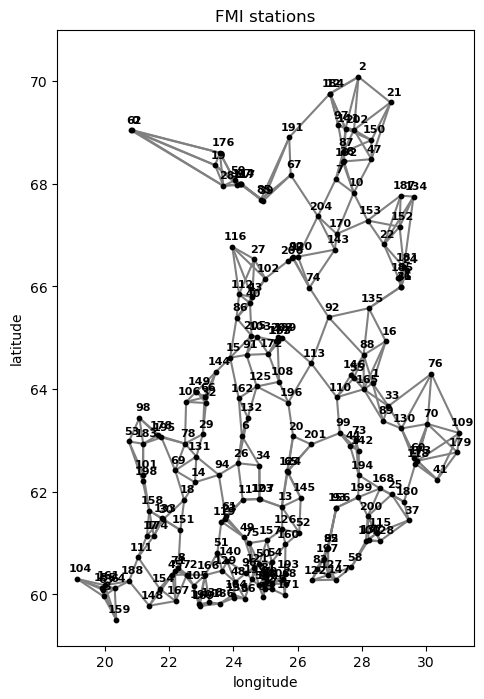

In [14]:
# Create a networkX graph
G_FMI_no_edges = nx.Graph()

# Add a one node per station
G_FMI_no_edges.add_nodes_from(range(n_stations))

for i, station in enumerate(data.name.unique()):
    # Extract data of a certain station
    station_data = data[data.name==station]
    
    # Extract features and labels
    X_node, y_node = ExtractFeatureMatrixLabelVector(station_data)
    
    # Split the dataset into training and validation set
    X_train, X_test, y_train, y_test = train_test_split(X_node, y_node, test_size=0.2, random_state=seed)

    # Assign node attributes
    G_FMI_no_edges.nodes[i].update({
        'name': station, # The name of the i-th weather station
        'user_name': None, # The name of user at i-th weather station
        'coord': (station_data.Latitude.iloc[0], station_data.Longitude.iloc[0]), # The coordinates of the i-th weather station
        'X_train': X_train, # The training feature matrix for local dataset at node i
        'y_train': y_train, # The training label vector for local dataset at node i
        'X_test': X_test, # The test feature matrix for local dataset at node i
        'y_test': y_test, # The test label vector for local dataset at node i
    })
    
# Add edges between each station and its nearest neighbors.
# NOTE: the node degree might be different for different nodes
G_FMI = add_edges(G_FMI_no_edges, numneighbors=4)
print("The empirical graph is connected:", nx.is_connected(G_FMI))

# Visualize the empirical graph
plotFMI(G_FMI)

## FedGD 

In [15]:
def FedGD(graph_FMI, 
          alpha=0.5, 
          l_rate=0.1, 
          max_iter=1000, 
          tol=0.0001, 
          logging=False):
    """
    Performs Federated Gradient Descent (FedGD) on a network of FMI stations, 
    where each node updates its local model while incorporating neighbor influence.

    Parameters
    ----------
    graph_FMI : networkx.Graph
        A graph where each node represents a station with:
        - 'X_train' (numpy.ndarray): Feature matrix for local training.
        - 'y_train' (numpy.ndarray): Target values.
        - 'weights' (numpy.ndarray): Initial weight vector (initialized as zeros).
    
    alpha : float, optional (default=0.5)
        Regularization parameter controlling the influence of neighboring nodes.

    l_rate : float, optional (default=0.1)
        Learning rate for the gradient descent updates.

    max_iter : int, optional (default=1000)
        Maximum number of iterations for gradient descent.

    tol : float, optional (default=0.0001)
        Convergence threshold based on the average weight change.

    logging : bool, optional (default=False)
        If True, prints the average weight change at each iteration.

    Returns
    -------
    graph : networkx.Graph
        A modified copy of `graph_FMI` where each node's 'weights' attribute 
        contains the trained model parameters.

    Notes
    -----
    - The algorithm performs synchronous updates across nodes.
    - The stopping criterion is based on weight change convergence.
    - If `max_iter` is reached, a message is printed indicating termination.
    """ 
    # Deep copy the input graph
    graph = copy.deepcopy(graph_FMI)

    # Initialize weights at each node with zeros
    for node in graph.nodes:
        graph.nodes[node]['weights'] = np.zeros((graph.nodes[node]['X_train'].shape[1], 1))

    # Federated gradient descent
    prev_avg_delta_w = 1001
    curr_avg_delta_w = 1000
    i = 0
    while i < max_iter and prev_avg_delta_w - curr_avg_delta_w > tol:
        # Compute updated weights for all nodes
        delta_w = {}
        updates = {}
        for node in graph.nodes:
            X_train, y_train = graph.nodes[node]['X_train'], graph.nodes[node]['y_train']
            w_current = graph.nodes[node]['weights']
            term_1 = (2 / len(y_train)) * X_train.T.dot(X_train.dot(w_current) - y_train)
            term_2 = 2 * alpha * sum(
                w_current - graph.nodes[neighbor]['weights'] for neighbor in graph.neighbors(node)
            )
            updates[node] = w_current - l_rate * (term_1 + term_2)

        # Apply updates synchronously
        for node, new_weights in updates.items():
            delta_w[node] = np.linalg.norm(graph.nodes[node]['weights'] - new_weights)
            graph.nodes[node]['weights'] = new_weights

        # Calculate the average of weight differences
        prev_avg_delta_w = curr_avg_delta_w
        curr_avg_delta_w = np.array(list(delta_w.values())).mean()
        if logging:
            print(f"Iteration #{i}: avg_delta_w = {curr_avg_delta_w}")

        # Iteration step
        i += 1

    # Logging
    if i == max_iter:
        print(f"Maximum iteration reached\n")
    else:
        print(f"Convergence reached at iteration #{i}\n")

    return graph

## FedGD with Subjective Explainability

One of the key requirements for trustworthy AI is __Transparency__ (see Section 8.2.4 in [FLBook](https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FLBook.pdf)). The transparent FL system must include good explainability of the trained local models. We can measure the explainability of the trained model by comparing the prediciton with the guess made by the user. Therefore, the penalty term can be added to the local loss function:

$$
L_i(\mathbf{w}^{(i)}) := \underbrace{\frac{1}{m_i} \| \mathbf{X}^{(i)}\mathbf{w}^{({i})} - \mathbf{y}^{(i)}\|_2^2}_{\text{training error}} + \underbrace{\rho \frac{1}{|D_t^{(i)}|} \sum_{\mathbf{x} \in D_t^{(i)}}{\left(\mathbf{x}^T \mathbf{w}^{(i)} - u^{(i)}(\mathbf{x})\right)^2}}_{\text{subjective explainability}}
$$

Now, we can formulate the gradient step with Subjective Explainability penalty term:

$$
\mathbf{w}^{(k+1)} := \mathbf{w}^{(k)} - \eta \nabla f(\mathbf{w}^{(k)}) \text{, where}\\
\{ \hat{\mathbf{w}}^{(i)}\}_{i=1}^n \in \underset{\{\mathbf{w}^{(i)}\}}{\text{argmin}} \underbrace{\sum_{i \in \mathcal{V}}{\overbrace{L_i(\mathbf{w}^{(i)})}^{\text{local loss}} + \alpha \sum_{\{i, i'\} \in \mathcal{E}}{A_{i, i'} \|\mathbf{w}^{(i)}-\mathbf{w}^{(i')}\|_2^2}}}_{=: f(\mathbf{w})}
\\
\text{and}
\\
L_i(\mathbf{w}^{(i)}) := \underbrace{\frac{1}{m_i} \| \mathbf{X}^{(i)}\mathbf{w}^{({i})} - \mathbf{y}^{(i)}\|_2^2}_{\text{training error}} + \underbrace{\rho \frac{1}{|D_t^{(i)}|} \sum_{\mathbf{x} \in D_t^{(i)}}{\left(\mathbf{x}^T \mathbf{w}^{(i)} - u^{(i)}(\mathbf{x})\right)^2}}_{\text{subjective explainability}}
$$

<a id='varying_features'></a>
<div class=" alert alert-warning">

### Task 6.1 - Subjective Explainability
    
__Task description:__ 
1. Calculate the gradient of the Subjective Explainability penalty term.
2. Modify the previously defined `FedGD` function according to the gradient step with Subjective Explainability formula.
    
__Hints:__ 
1. Read Section 8.4 in the [FLBook](https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FLBook.pdf).
</div>

In [16]:
# Let's assume the subjective explainability is sufficient.
# Therefore, we define it by adding the noise to the true values.
np.random.seed(seed)
for node in G_FMI.nodes:
    y_test = G_FMI.nodes[node]['y_test']
    noise = y_test * np.random.uniform(-0.01, 0.01)  # Noise is ±10% of true values
    G_FMI.nodes[node]['u'] = y_test + noise

In [17]:
def FedGD_Exp(graph_FMI, 
              alpha=0.5, 
              rho=0.5, 
              l_rate=0.05, 
              max_iter=1000, 
              tol=0.0001, 
              logging=False):
    """
    Performs an extended version of Federated Gradient Descent (FedGD) incorporating 
    subjective explainability constraints.

    Parameters
    ----------
    graph_FMI : networkx.Graph
        A graph where each node represents an FMI station, containing:
        - 'X_train' (numpy.ndarray): Feature matrix for local training.
        - 'y_train' (numpy.ndarray): Target values for training.
        - 'X_test' (numpy.ndarray): Feature matrix for subjective explainability.
        - 'u' (numpy.ndarray): User signal values indicating explainability preferences.
        - 'weights' (numpy.ndarray): Initialized weight vector (set to zeros).

    alpha : float, optional (default=0.5)
        Regularization parameter controlling the influence of neighboring nodes.

    rho : float, optional (default=0.5)
        Weight for the subjective explainability term in the gradient update.

    l_rate : float, optional (default=0.05)
        Learning rate for the gradient descent updates.

    max_iter : int, optional (default=1000)
        Maximum number of iterations for gradient descent.

    tol : float, optional (default=0.0001)
        Convergence threshold based on the average weight change.

    logging : bool, optional (default=False)
        If True, prints the average weight change at each iteration.

    Returns
    -------
    graph : networkx.Graph
        A modified copy of `graph_FMI` where each node's 'weights' attribute 
        contains the trained model parameters.

    Notes
    -----
    - The algorithm performs synchronous updates across all nodes.
    - The weight update rule consists of:
        (I) Training error gradient (local loss minimization).
        (II) Subjective explainability gradient (user preference enforcement).
        (III) Graph regularization gradient (neighboring influence).
    - The stopping criterion is based on weight change convergence.
    - If `max_iter` is reached, a message is printed indicating termination.
    """
    # Deep copy the input graph
    graph = copy.deepcopy(graph_FMI)

    # Initialize weights at each node with zeros
    for node in graph.nodes:
        graph.nodes[node]['weights'] = np.zeros((graph.nodes[node]['X_train'].shape[1], 1))

    # Federated gradient descent
    prev_avg_delta_w = 1001
    curr_avg_delta_w = 1000
    i = 0
    while i < max_iter and prev_avg_delta_w - curr_avg_delta_w > tol:
        # Compute updated weights for all nodes
        delta_w = {}
        updates = {}
        for node in graph.nodes:
            # Extract data for the current node
            X_train, y_train = graph.nodes[node]['X_train'], graph.nodes[node]['y_train']
            X_test, user_signals = graph.nodes[node]['X_test'], graph.nodes[node]['u']
            w_current = graph.nodes[node]['weights']

            # Term (I): Training error gradient
            term_1 = (2 / len(y_train)) * X_train.T.dot(X_train.dot(w_current) - y_train)

            ### TASK ###
            # Term (II): Subjective explainability gradient
            # term_2 = 

            ### BEGIN SOLUTION

            # Term (II): Subjective explainability gradient
            term_2 = (2 * rho / len(user_signals)) * X_test.T.dot(X_test.dot(w_current) - user_signals)
            ### END SOLUTION
            

            # Term (III): Graph regularization gradient
            term_3 = 2 * alpha * sum(
                w_current - graph.nodes[neighbor]['weights'] for neighbor in graph.neighbors(node)
            )
            
            # Update rule
            updates[node] = w_current - l_rate * (term_1 + term_2 + term_3)

        # Apply updates synchronously
        for node, new_weights in updates.items():
            delta_w[node] = np.linalg.norm(graph.nodes[node]['weights'] - new_weights)
            graph.nodes[node]['weights'] = new_weights

        # Calculate the average of weight differences
        prev_avg_delta_w = curr_avg_delta_w
        curr_avg_delta_w = np.array(list(delta_w.values())).mean()
        if logging:
            print(f"Iteration #{i}: avg_delta_w = {curr_avg_delta_w}")

        # Iteration step
        i += 1

    # Logging
    if i == max_iter:
        print(f"Maximum iteration reached\n")
    else:
        print(f"Convergence reached at iteration #{i}\n")
        
    return graph

In [18]:
# Perform Federated Gradient Descent with Subjective Explainability term 
# with default parameters
graph_trained_Exp = FedGD_Exp(G_FMI, 
                              alpha=0.5, 
                              rho=0.5, 
                              l_rate=0.05, 
                              max_iter=1000, 
                              tol=0.0001, 
                              logging=False)

# Extract the updated local models' parameters
weights_data_Exp = np.array([graph_trained_Exp.nodes[node]['weights'] for node in graph_trained_Exp.nodes])

# Perform Federated Gradient Descent with default parameters
graph_trained = FedGD(G_FMI, 
                      alpha=0.5, 
                      l_rate=0.05, 
                      max_iter=1000, 
                      tol=0.0001, 
                      logging=False)

# Extract the updated local models' parameters
weights_data = np.array([graph_trained.nodes[node]['weights'] for node in graph_trained.nodes])

print(f"Basic FedGD: the final weights for the node #0 is\n{weights_data[0]}\n")
print(f"FedGD with Subjective Explainability term: the final weights for the node #0 is\n{weights_data_Exp[0]}\n")

# Sanity checks

# The output of FedGD_Exp must be different from FedGD
assert np.all(weights_data[:, :-1] != weights_data_Exp[:, :-1]), "FedGD and FedGD_Exp must result in different model parameters!"

print('Sanity check passed!')

### BEGIN HIDDEN TESTS
def test_FedGD_Exp(graph_FMI, 
                   alpha=0.5, 
                   rho=0.5, 
                   l_rate=0.05, 
                   max_iter=1000, 
                   tol=0.0001):
    
    # Deep copy the input graph
    graph = copy.deepcopy(graph_FMI)

    # Initialize weights at each node with zeros
    for node in graph.nodes:
        graph.nodes[node]['weights'] = np.zeros((graph.nodes[node]['X_train'].shape[1], 1))

    # Federated gradient descent
    prev_avg_delta_w = 1001
    curr_avg_delta_w = 1000
    i = 0
    while i < max_iter and prev_avg_delta_w - curr_avg_delta_w > tol:
        # Compute updated weights for all nodes
        delta_w = {}
        updates = {}
        for node in graph.nodes:
            # Extract data for the current node
            X_train, y_train = graph.nodes[node]['X_train'], graph.nodes[node]['y_train']
            X_test, user_signals = graph.nodes[node]['X_test'], graph.nodes[node]['u']
            w_current = graph.nodes[node]['weights']

            # Term (I): Training error gradient
            term_1 = (2 / len(y_train)) * X_train.T.dot(X_train.dot(w_current) - y_train)

            # Term (II): Subjective explainability gradient
            term_2 = (2 * rho / len(user_signals)) * X_test.T.dot(X_test.dot(w_current) - user_signals)

            # Term (III): Graph regularization gradient
            term_3 = 2 * alpha * sum(
                w_current - graph.nodes[neighbor]['weights'] for neighbor in graph.neighbors(node)
            )

            # Update rule
            updates[node] = w_current - l_rate * (term_1 + term_2 + term_3)

        # Apply updates synchronously
        for node, new_weights in updates.items():
            delta_w[node] = np.linalg.norm(graph.nodes[node]['weights'] - new_weights)
            graph.nodes[node]['weights'] = new_weights

        # Calculate the average of weight differences
        prev_avg_delta_w = curr_avg_delta_w
        curr_avg_delta_w = np.array(list(delta_w.values())).mean()

        # Iteration step
        i += 1
        
    return graph

# Perform Federated Gradient Descent with Subjective Explainability term 
# with default parameters
test_graph_trained_Exp = test_FedGD_Exp(G_FMI, 
                                        alpha=0.5, 
                                        rho=0.5, 
                                        l_rate=0.05, 
                                        max_iter=1000, 
                                        tol=0.0001)

# Extract the updated local models' parameters at node 84
test_weights_data_Exp = np.array([test_graph_trained_Exp.nodes[node]['weights'] for node in test_graph_trained_Exp.nodes])

test_weights_84 = test_weights_data_Exp[84]
weights_84 = weights_data_Exp[84]

# It compares the difference between actual and desired to 
# atol + rtol * abs(desired).
# Tolerance 1%: rtol=0.1 and atol=0
np.testing.assert_allclose(actual=weights_84, 
                           desired=test_weights_84, 
                           rtol=0.01, 
                           atol=0)
### END HIDDEN TESTS

Convergence reached at iteration #238

Convergence reached at iteration #279

Basic FedGD: the final weights for the node #0 is
[[ -7.41060299]
 [ -2.80323943]
 [-10.90673419]
 [  0.95166388]
 [  0.13977734]
 [ -0.66909056]
 [  0.        ]]

FedGD with Subjective Explainability term: the final weights for the node #0 is
[[-7.35192709e+00]
 [-2.79042271e+00]
 [-1.08154663e+01]
 [ 1.27947524e+00]
 [ 2.32488878e-03]
 [-3.95875273e-02]
 [ 0.00000000e+00]]

Sanity check passed!


## FedGD with Zero-Loss Nodes

A malicious node within an empirical graph can exploit the training process by setting its local loss function to zero, thereby replicating the model weights of its neighboring nodes. This adversarial strategy enables the node to acquire sensitive information embedded within these weights, potentially compromising the privacy of the system.

In the following task, we simulate the described attack by designating two nodes: Alice as the victim and Bob as the attacker.

<a id='varying_features'></a>
<div class=" alert alert-warning">

### Task 6.2 - Privacy Attack- Where is Alice?

__Task description:__ 
1. Analyze the `FedGD_zero_loss` function and apply it to the `G_Alice_Bob` empirical graph.
2. Determine the appropriate input parameter values that enable Bob to replicate Alice's local model parameters.
    
</div>

### Data preparation

For simplicity, we redefine the features and labels for the data points as follows:

* __Features:__ The number of days since December 1st.
* __Label:__ The average daily temperature.

Furthermore, we apply `StandardScaler()` to standardize both features and labels.

In [10]:
# Define the reference date as 1st December of the same year
reference_date = pd.Timestamp(year=2023, month=12, day=1)

# Calculate days elapsed since 01-12
data["winter_day"] = (data["Timestamp"] - reference_date).dt.days

# Aggregate the data by day and name
daily_avg_temp = data.groupby(["winter_day", "name"]).agg(
    avg_temp=("temp", "mean"),
    Latitude=("Latitude", "first"),
    Longitude=("Longitude", "first"),
).reset_index()

# Standardize 'winter_day' and 'avg_temp'
scaler_winter_day = StandardScaler()
scaler_avg_temp = StandardScaler()
daily_avg_temp['winter_day_scaled'] = scaler_winter_day.fit_transform(daily_avg_temp['winter_day'].values.reshape(-1, 1))
daily_avg_temp['avg_temp_scaled'] = scaler_avg_temp.fit_transform(daily_avg_temp['avg_temp'].values.reshape(-1, 1))

print(f"The data point example:")
print(daily_avg_temp[daily_avg_temp['name'] == 'Alajärvi Möksy'])

G_Alice_Bob = copy.deepcopy(G_FMI_no_edges)
for node, attrs in G_Alice_Bob.nodes(data=True):
    station = attrs['name']
    station_data = daily_avg_temp[daily_avg_temp['name'] == station]
    X_train = station_data['winter_day_scaled'].values.reshape(-1, 1)
    y_train = station_data['avg_temp_scaled'].values.reshape(-1, 1)
    G_Alice_Bob.nodes[node]['X_train'] = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    G_Alice_Bob.nodes[node]['y_train'] = y_train
    
    # Remove 'X_test' and 'y_test' if they exist
    G_Alice_Bob.nodes[node].pop('X_test', None)
    G_Alice_Bob.nodes[node].pop('y_test', None)

The data point example:
     winter_day            name   avg_temp  Latitude  Longitude  \
0            27  Alajärvi Möksy  -5.784615  63.08898   24.26084   
207          28  Alajärvi Möksy  -6.895833  63.08898   24.26084   
413          29  Alajärvi Möksy -13.479167  63.08898   24.26084   
619          30  Alajärvi Möksy -19.916667  63.08898   24.26084   
826          31  Alajärvi Möksy -24.636364  63.08898   24.26084   

     winter_day_scaled  avg_temp_scaled  
0            -1.413872         0.782669  
207          -0.707278         0.631292  
413          -0.000684        -0.265531  
619           0.705910        -1.142488  
826           1.412504        -1.785435  


In [11]:
def FedGD_zero_loss(graph_FMI, 
                    zero_loss_nodes=[], 
                    alpha=0.5, 
                    l_rate=0.1,
                    max_iter=1000, 
                    tol=0.0001, 
                    logging=False, 
                    n_init=5):
    """
    Performs Federated Gradient Descent (FedGD) with multiple random initializations,
    enforcing zero loss on specified nodes.

    Parameters
    ----------
    graph_FMI : networkx.Graph
        A graph where each node represents a station, containing:
        - 'X_train' (numpy.ndarray): Feature matrix for local training.
        - 'y_train' (numpy.ndarray): Target values for training.
        - 'weights' (numpy.ndarray): Model parameters, initialized randomly.

    zero_loss_nodes : list, optional (default=[])
        List of node IDs where the loss term is ignored during updates, 
        enforcing zero loss for those nodes.

    alpha : float, optional (default=0.5)
        Regularization parameter controlling the influence of neighboring nodes.

    l_rate : float, optional (default=0.1)
        Learning rate for the gradient descent updates.

    max_iter : int, optional (default=1000)
        Maximum number of iterations for gradient descent.

    tol : float, optional (default=0.0001)
        Convergence threshold based on the average weight change.

    logging : bool, optional (default=False)
        If True, prints the average weight change and iteration progress.

    n_init : int, optional (default=5)
        Number of random initializations to find the best-performing model.

    Returns
    -------
    best_graph : networkx.Graph
        A modified copy of `graph_FMI` where each node's 'weights' attribute 
        contains the trained model parameters, optimized over multiple initializations.

    Notes
    -----
    - The algorithm runs `n_init` times with different random initializations, selecting 
      the model with the lowest average training loss.
    - The weight update rule consists of:
        (I) Training error gradient (for regular nodes).
        (II) Graph regularization gradient (neighboring influence).
    - Nodes in `zero_loss_nodes` update weights only using regularization.
    - The stopping criterion is based on weight change convergence.
    - If `max_iter` is reached, a message is printed indicating termination.
    """
    best_graph = None
    best_avg_loss = float('inf')  # We will use the lowest average loss over nodes as the criteria
    
    np.random.seed(seed)
    for init_iter in range(n_init):
        print(f"Running initialization {init_iter + 1}/{n_init}")
        
        # Deep copy the input graph to reset the weights for each initialization
        graph = copy.deepcopy(graph_FMI)
        
        # Initialize weights at each node (random initialization)
        for node in graph.nodes:
            # Initialize weights
            graph.nodes[node]['weights'] = np.random.uniform(-1, 1, (graph.nodes[node]['X_train'].shape[1], 1))

        # Federated gradient descent
        prev_avg_delta_w = 1001
        curr_avg_delta_w = 1000
        i = 0
        while i < max_iter and prev_avg_delta_w - curr_avg_delta_w > tol:
            # Compute updated weights for all nodes
            delta_w = {}
            updates = {}
            for node in graph.nodes:
                X_train, y_train = graph.nodes[node]['X_train'], graph.nodes[node]['y_train']
                w_current = graph.nodes[node]['weights']
                term_1 = (2 / len(y_train)) * X_train.T.dot(X_train.dot(w_current) - y_train)
                term_2 = 2 * alpha * sum(
                    w_current - graph.nodes[neighbor]['weights'] for neighbor in graph.neighbors(node)
                )
                # Zero loss for the defined nodes
                if node in zero_loss_nodes:
                    updates[node] = w_current - l_rate * term_2
                else:
                    updates[node] = w_current - l_rate * (term_1 + term_2)

            # Apply updates synchronously
            for node, new_weights in updates.items():
                delta_w[node] = np.linalg.norm(graph.nodes[node]['weights'] - new_weights)
                graph.nodes[node]['weights'] = new_weights
                
            # Calculate the average of weight differences
            prev_avg_delta_w = curr_avg_delta_w
            curr_avg_delta_w = np.array(list(delta_w.values())).mean()
            if logging:
                print(f"Iteration #{i}: avg_delta_w = {curr_avg_delta_w}")

            # Iteration step
            i += 1

        # Check if this initialization produced the best result
        avg_loss = 0
        for node, attr in graph.nodes(data=True):
            local_loss = mean_squared_error(attr['y_train'], attr['X_train'].dot(attr['weights']))
            avg_loss += local_loss
        avg_loss /= len(graph.nodes)
        
        if avg_loss < best_avg_loss:
            print(f"The best loss is updated: {avg_loss}")
            best_avg_loss = avg_loss
            best_graph = graph
            
        # Logging
        if i == max_iter:
            print(f"Initialization {init_iter + 1}: Maximum iteration reached\n")
        else:
            print(f"Initialization {init_iter + 1}: Convergence reached at iteration #{i}\n")

    # Return the best result after testing all initializations
    return best_graph

### Alice

In [12]:
# Define the node Alice at location Vantaa Helsinki-Vantaan lentoasema
Alice_node_id = 0
for node_id, attrs in G_Alice_Bob.nodes(data=True):
    if attrs['name'] == "Vantaa Helsinki-Vantaan lentoasema":
        Alice_node_id = node_id
        G_Alice_Bob.nodes[node_id]['user_name'] = "Alice"
        break
        
print(f"Alice is located at node #{Alice_node_id}")

Alice is located at node #81


### Bob

In [13]:
# Define the node Bob at location Oulu lentoasema
Bob_node_id = 0
for node_id, attrs in G_Alice_Bob.nodes(data=True):
    if attrs['name'] == "Oulu lentoasema":
        Bob_node_id = node_id
        G_Alice_Bob.nodes[node_id]['user_name'] = "Bob"
        break
        
print(f"Bob is located at node #{Bob_node_id}")

# Add an edge between Bob's and Alice's nodes
G_Alice_Bob.add_edge(Alice_node_id, Bob_node_id, weight=1)

Bob is located at node #177


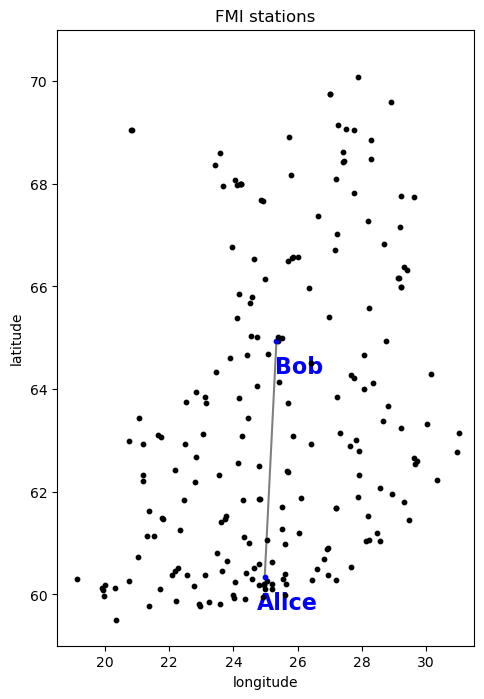

In [14]:
plotFMI(G_Alice_Bob, show_IDs=False)

### Train the local models

In [15]:
### TASK ###
# Choose the attributes and apply the Federated Gradient Descent alogorithm 
# to the G_Alice_Bob, so Bob replicates Alice's local model parameters.
# IMPORTANT: all solutions that replicate the Alice's weights without applying FedGD_zero_loss(...)
#            will receive 0 points!!!

# G_Alice_Bob_trained = FedGD_zero_loss(...)
 
### BEGIN SOLUTION
G_Alice_Bob_trained = FedGD_zero_loss(G_Alice_Bob, 
                                      zero_loss_nodes=[Bob_node_id], 
                                      alpha=10,
                                      l_rate=0.001, 
                                      max_iter=1000, 
                                      tol=0, 
                                      logging=False,
                                      n_init=20)
### END SOLUTION

print(f"{G_Alice_Bob_trained.nodes[Alice_node_id]['user_name']} is located at {G_Alice_Bob_trained.nodes[Alice_node_id]['name']}")
print(f"The local model parameters are\n{G_Alice_Bob_trained.nodes[Alice_node_id]['weights']}\n")
print(f"{G_Alice_Bob_trained.nodes[Bob_node_id]['user_name']} is located at {G_Alice_Bob_trained.nodes[Bob_node_id]['name']}")
print(f"The local model parameters are\n{G_Alice_Bob_trained.nodes[Bob_node_id]['weights']}")

Running initialization 1/20
The best loss is updated: 0.13000172582799263
Initialization 1: Maximum iteration reached

Running initialization 2/20
Initialization 2: Maximum iteration reached

Running initialization 3/20
Initialization 3: Maximum iteration reached

Running initialization 4/20
Initialization 4: Maximum iteration reached

Running initialization 5/20
Initialization 5: Maximum iteration reached

Running initialization 6/20
The best loss is updated: 0.12796860524662132
Initialization 6: Maximum iteration reached

Running initialization 7/20
Initialization 7: Maximum iteration reached

Running initialization 8/20
Initialization 8: Maximum iteration reached

Running initialization 9/20
Initialization 9: Maximum iteration reached

Running initialization 10/20
Initialization 10: Maximum iteration reached

Running initialization 11/20
Initialization 11: Maximum iteration reached

Running initialization 12/20
Initialization 12: Maximum iteration reached

Running initialization 13/

In [16]:
# Sanity checks

# Check if the chosen answer option is adequate
w_Alice = G_Alice_Bob_trained.nodes[Alice_node_id]['weights']
w_Bob = G_Alice_Bob_trained.nodes[Bob_node_id]['weights']

assert np.allclose(w_Alice, w_Bob, atol=0.03), "Bob's weights must be similar to Alice's ones!"

print('Sanity check passed!')

### BEGIN HIDDEN TESTS
np.testing.assert_allclose(w_Alice, w_Bob, atol=0.03)
assert np.all(G_Alice_Bob_trained.nodes[101]['weights'] != 0)
### END HIDDEN TESTS

Sanity check passed!


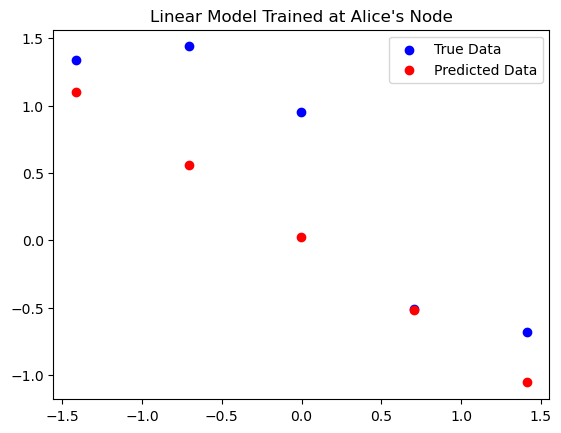

In [17]:
# Extract weights, features, and labels
w_Alice = G_Alice_Bob_trained.nodes[Alice_node_id]['weights']
X_Alice = G_Alice_Bob_trained.nodes[Alice_node_id]['X_train'][:, 0].reshape(-1, 1)
y_Alice = G_Alice_Bob_trained.nodes[Alice_node_id]['y_train']

# Plot actual data points
plt.scatter(X_Alice, y_Alice, c='b', label='True Data')

# Plot predictions from the trained model
plt.scatter(X_Alice, X_Alice.dot(w_Alice[0, :]) + w_Alice[1, :], c='r', label='Predicted Data')

# Add title and legend
plt.title("Linear Model Trained at Alice's Node")
plt.legend()
plt.show()

### Find the Alice's location

Now that Bob's local weights replicate those of Alice, he can systematically examine all stations, compare the model weights, and infer Alice's location.

In [18]:
n_nearest = 2
w_Bob = G_Alice_Bob_trained.nodes[Bob_node_id]['weights']

delta_w = {}
for node_id, attrs in G_Alice_Bob_trained.nodes(data=True):
    w_local = attrs['weights']
    delta_w[node_id] = mean_squared_error(w_local, w_Bob)
        
# Get the n_nearest nodes with the smallest values in delta_w
n_nearest_nodes = sorted(delta_w.items(), key=lambda x: x[1])[:n_nearest]

# Extract only the node IDs (or keep the node ID-value pairs if needed)
n_nearest_node_ids = [node_id for node_id, _ in n_nearest_nodes]

# Print the results
print(f"The {n_nearest} nearest nodes based on delta_w:")
print(n_nearest_node_ids)

# Sanity check
assert set(n_nearest_node_ids) == set([Alice_node_id, Bob_node_id])
print("Sanity check passed!")

### BEGIN HIDDEN TESTS
assert set(n_nearest_node_ids) == set([Alice_node_id, Bob_node_id])
### END HIDDEN TESTS

The 2 nearest nodes based on delta_w:
[177, 81]
Sanity check passed!


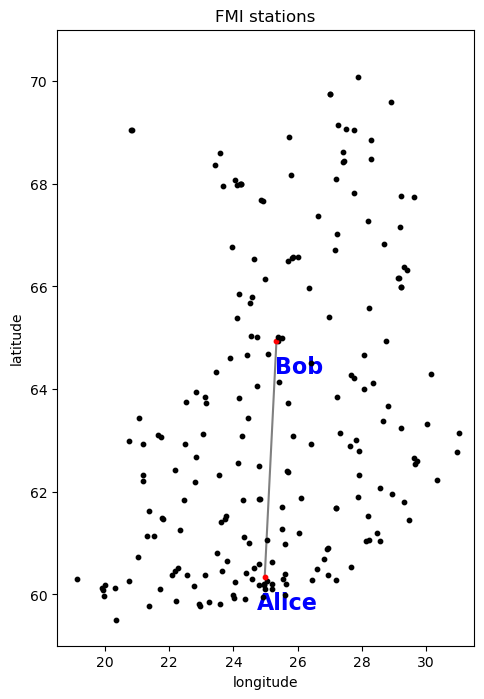

In [19]:
plotFMI(G_Alice_Bob_trained, show_IDs=False, nodes_red=n_nearest_node_ids)

<a id='varying_features'></a>
<div class=" alert alert-warning">

### Question 6.1 - AI key requirements

__Formulation:__
    
The European Commission set up the High-Level Expert Group on Artificial Intelligence (AI HLEG) in 2018. What requirement for trustworthy AI was not put forward? 

__Note:__ 
    
The requirements are rephrased. Pay attention to the meaning, not wording.

__Answer Options:__

1. A robot may not injure a human being or, through inaction, allow a human being to come to harm.
2.  Accountability must be ensured for AI systems and their outcomes, both before and after their development, deployment and use.
3. Prevention of harm to privacy and adequate data governance.
4. AI systems must reliably behave as intended while minimizing unintentional and unexpected harm, and preventing unacceptable harm.

</div>

In [20]:
### Question ###

# Assign the variable to the answer option from the list above
# answer =

### BEGIN SOLUTION
answer = 1
### END SOLUTION

In [21]:
# Sanity checks

# Check if the chosen answer option is adequate
assert answer in [1, 2, 3, 4], "Choose the answer option from the provided list."

print('Sanity check passed!')

### BEGIN HIDDEN TESTS
test_answer = 1
np.testing.assert_equal(actual = answer,
                        desired = test_answer)
### END HIDDEN TESTS

Sanity check passed!


<a id='varying_features'></a>
<div class=" alert alert-warning">

### Question 6.2 - Explainability

__Formulation:__
    
What does the explainability of a trained personalized model imply?

__Answer Options:__

1. The model must replicate the acknowledged formulas.
2. A human can replicate the model and perform the prediction delivery process.
3. A human can guess the prediction delivered by the model with a certain level of accuracy. 
4. The model structure must be available to public.

</div>

In [22]:
### Question ###

# Assign the variable to the answer option from the list above
# answer =

### BEGIN SOLUTION
answer = 3
### END SOLUTION

In [23]:
# Sanity checks

# Check if the chosen answer option is adequate
assert answer in [1, 2, 3, 4], "Choose the answer option from the provided list."

print('Sanity check passed!')

### BEGIN HIDDEN TESTS
test_answer = 3
np.testing.assert_equal(actual = answer,
                        desired = test_answer)
### END HIDDEN TESTS

Sanity check passed!
